## Conv Net을 사용한 시퀀스 처리
컴퓨터 비전에서 뛰어난 성능을 보이는 컨브넷(Conv Net)의 특징이 시퀀스 처리와도 관련되어 있음  
-> 시간을 2D 이미지의 높이와 너비 같은 공간의 차원으로 다룰 수 있음

### 1D Conv
특정 시퀀스 처리 문제에서 RNN과 견줄 만한 성능을 보임  
-> 1D Conv는 전형적으로 **팽창된 커널(dilated kernel)** 과 함께 사용 됨  
-> 최근 오디오 생성과 기계 번역 분야에서 큰 성공  
-> 텍스트 분류나 시계열 예측 같은 간단한 문제에서 작은 1D 컨브넷이 RNN을 대신해 빠르게 처리 가능


1D 합성곱은 시퀀스에 있는 지역 패턴을 인식할 수 있음  
-> 동일한 변환이 시퀀스에 있는 모든 패치에 적용되기 때문에 특정 위치에서 학습한 패턴을 나중에 다른 위치에서 인식 가능 (이동 불변성(translation invariant))  

#### 서브 샘플링(SubSampling)
1D 풀링 연산은 2D 풀링 연산과 동일  
-> 입력의 길이를 줄이기 위해 사용

In [2]:
import tensorflow as tf
from keras.datasets import imdb
from keras.utils import pad_sequences

max_features = 10000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(f"x_train: {len(x_train)}\nx_test: {len(x_test)}")

print("시퀀스 패딩 (samples x time)")
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print(f"x_train: {len(x_train)}\nx_test: {len(x_test)}")

x_train: 25000
x_test: 25000
시퀀스 패딩 (samples x time)
x_train: 25000
x_test: 25000


1D 컨브넷은 2D 컨브넷과 비슷한 방식으로 구성  
-> Conv + Pooling or Flatten + Dense

2D 컨브넷에서 3*3 합성곱 윈도우는 9개의 특성을 고려함  
-> 1D 컨브넷에선 크기가 3인 합성곱 윈도우는 3개의 특성만 고려  
-> 큰 합성곱 윈도우를 사용할 수 있음 (7 or 9)

In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation="relu"))
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(32, 7, activation="relu"))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 3

In [4]:
model.compile(
    optimizer=RMSprop(),
    loss="binary_crossentropy",
    metrics=["acc"]
)

with tf.device(":/GPU:0"):
    hist = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 21s 33ms/step - loss: 0.5354 - acc: 0.7829 - val_loss: 0.4572 - val_acc: 0.8754
Epoch 2/10
625/625 [==============================] - 16s 26ms/step - loss: 0.4106 - acc: 0.8919 - val_loss: 0.4135 - val_acc: 0.8762
Epoch 3/10
625/625 [==============================] - 21s 33ms/step - loss: 0.3158 - acc: 0.9291 - val_loss: 0.6973 - val_acc: 0.8586
Epoch 4/10
625/625 [==============================] - 20s 32ms/step - loss: 0.2463 - acc: 0.9602 - val_loss: 0.6839 - val_acc: 0.8826
Epoch 5/10
625/625 [==============================] - 19s 31ms/step - loss: 0.1908 - acc: 0.9780 - val_loss: 0.9289 - val_acc: 0.8804
Epoch 6/10
625/625 [==============================] - 19s 31ms/step - loss: 0.1657 - acc: 0.9837 - val_loss: 0.9730 - val_acc: 0.8788
Epoch 7/10
625/625 [==============================] - 20s 32ms/step - loss: 0.1527 - acc: 0.9858 - val_loss: 1.1627 - val_acc: 0.8786
Epoch 8/10
625/625 [==============================] - 17s 28ms

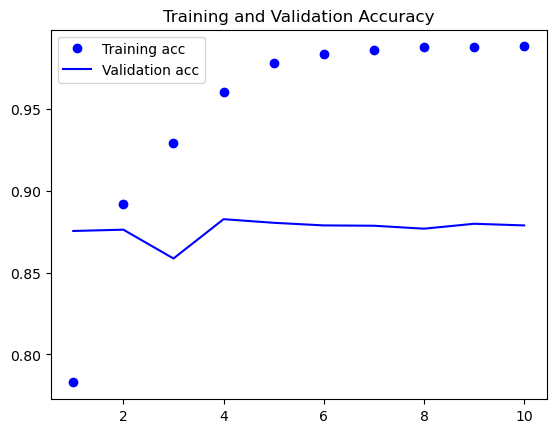

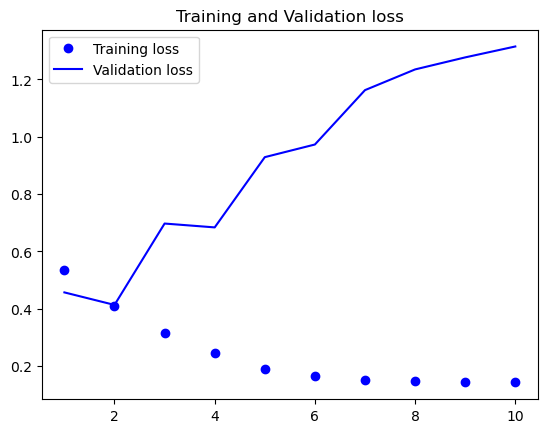

In [6]:
import matplotlib.pyplot as plt

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

### CNN과 RNN을 연결해 긴 시퀀스 처리하기
1D Conv넷은 입력 패치를 독립적으로 처리하기 때문에 RNN과 달리 타임스텝의 순서에 민감하지 않음  
-> 장기간 패턴을 인식하기 위해 많은 합성곱 층과 풀링 층을 쌓을 수 있음
